In [43]:
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd() )
print("mp", module_path)
# in standard python
#module_path = str(Path.cwd(__file__).parents[0] / "py")

if module_path not in sys.path:
    sys.path.append(module_path)



import warnings
import requests
from pyaxis import pyaxis
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
from scipy.stats import linregress
import ipywidgets as widgets
import mercury as mr
import data_helpers as dh
import plot_helpers as ph

style.use(f"file:plot.mplstyle")

json_body = {
  "query": [
    {
      "code": "village/city",
      "selection": {
        "filter": "agg:municipality-en-2017.agg",
        "values": [
          "4602"
        ]
      }
    },
    {
      "code": "month",
      "selection": {
        "filter": "item",
        "values": [
          "M01",
          "M02",
          "M03",
          "M04",
          "M05",
          "M06",
          "M07",
          "M08",
          "M09",
          "M10",
          "M11",
          "M12"
        ]
      }
    },
    {
      "code": "sex",
      "selection": {
        "filter": "item",
        "values": [
          "M",
          "F"
        ]
      }
    }
  ],
  "response": {
    "format": "px"
  }
}


mp d:\dev\hagstova\git\hagtol\fo_area_hagtol


In [44]:
regions = dh.get_regions()

region = mr.Select(value="suduroy", choices=regions, label="Øki")


mercury.Select

In [45]:
municipality = mr.Select(choices= dh.get_municipalities(region.value), label="Kommuna")


mercury.Select

In [46]:
filter, value = dh.get_filter(region.value, municipality.value)
#print(filter, value)
json_body["query"][0]["selection"]["filter"] = filter
json_body["query"][0]["selection"]["values"] = [value]

df = dh.fetch_data("v1/en/H2/IB/IB01/fo_vital_md.px", json_body, f"people-data-{region.value}-{municipality.value}")
df['date']=pd.to_datetime(df['month']+df['year'].astype(str),format='%b%Y')
df['value']=pd.to_numeric(df['DATA'])

rdf = pd.DataFrame()
rdf['date'] = df['date'].loc[(df["sex"] == "Males") & (df['changes'] == "Population primo")].reset_index()['date']

sexes = ["Males", "Females"]
changes = ["Population primo", "Live births" , "Deaths", "Immigration to The Faroe Islands", "Emigration from The Faroe Islands", "Domestic immigration", "Domestic emigration"]

net_columns = {
    "net births" : ["Live births", "Deaths"],
    "net domestic immigration": ["Domestic immigration", "Domestic emigration"],
    "net foreign": ["Immigration to The Faroe Islands", "Emigration from The Faroe Islands"]
}

for sex in sexes:
    for change in changes:
        rdf[sex + " " + change] = df['value'].loc[(df["sex"] == sex) & (df['changes'] == change)].reset_index()['value']

plot_columns = []
for sex in sexes:
    for column in net_columns:
        rdf[sex + " " + column] = rdf[sex + " " + net_columns[column][0]] - rdf[sex + " " + net_columns[column][1]]
        rdf["sum " + sex + " " + column] = rdf[sex + " " + column].cumsum()
        plot_columns.append("sum " + sex + " " + column)

rdf['sum']=rdf[plot_columns]. sum(axis=1)
plot_columns.insert(0, 'date')
plot_columns.append("sum")

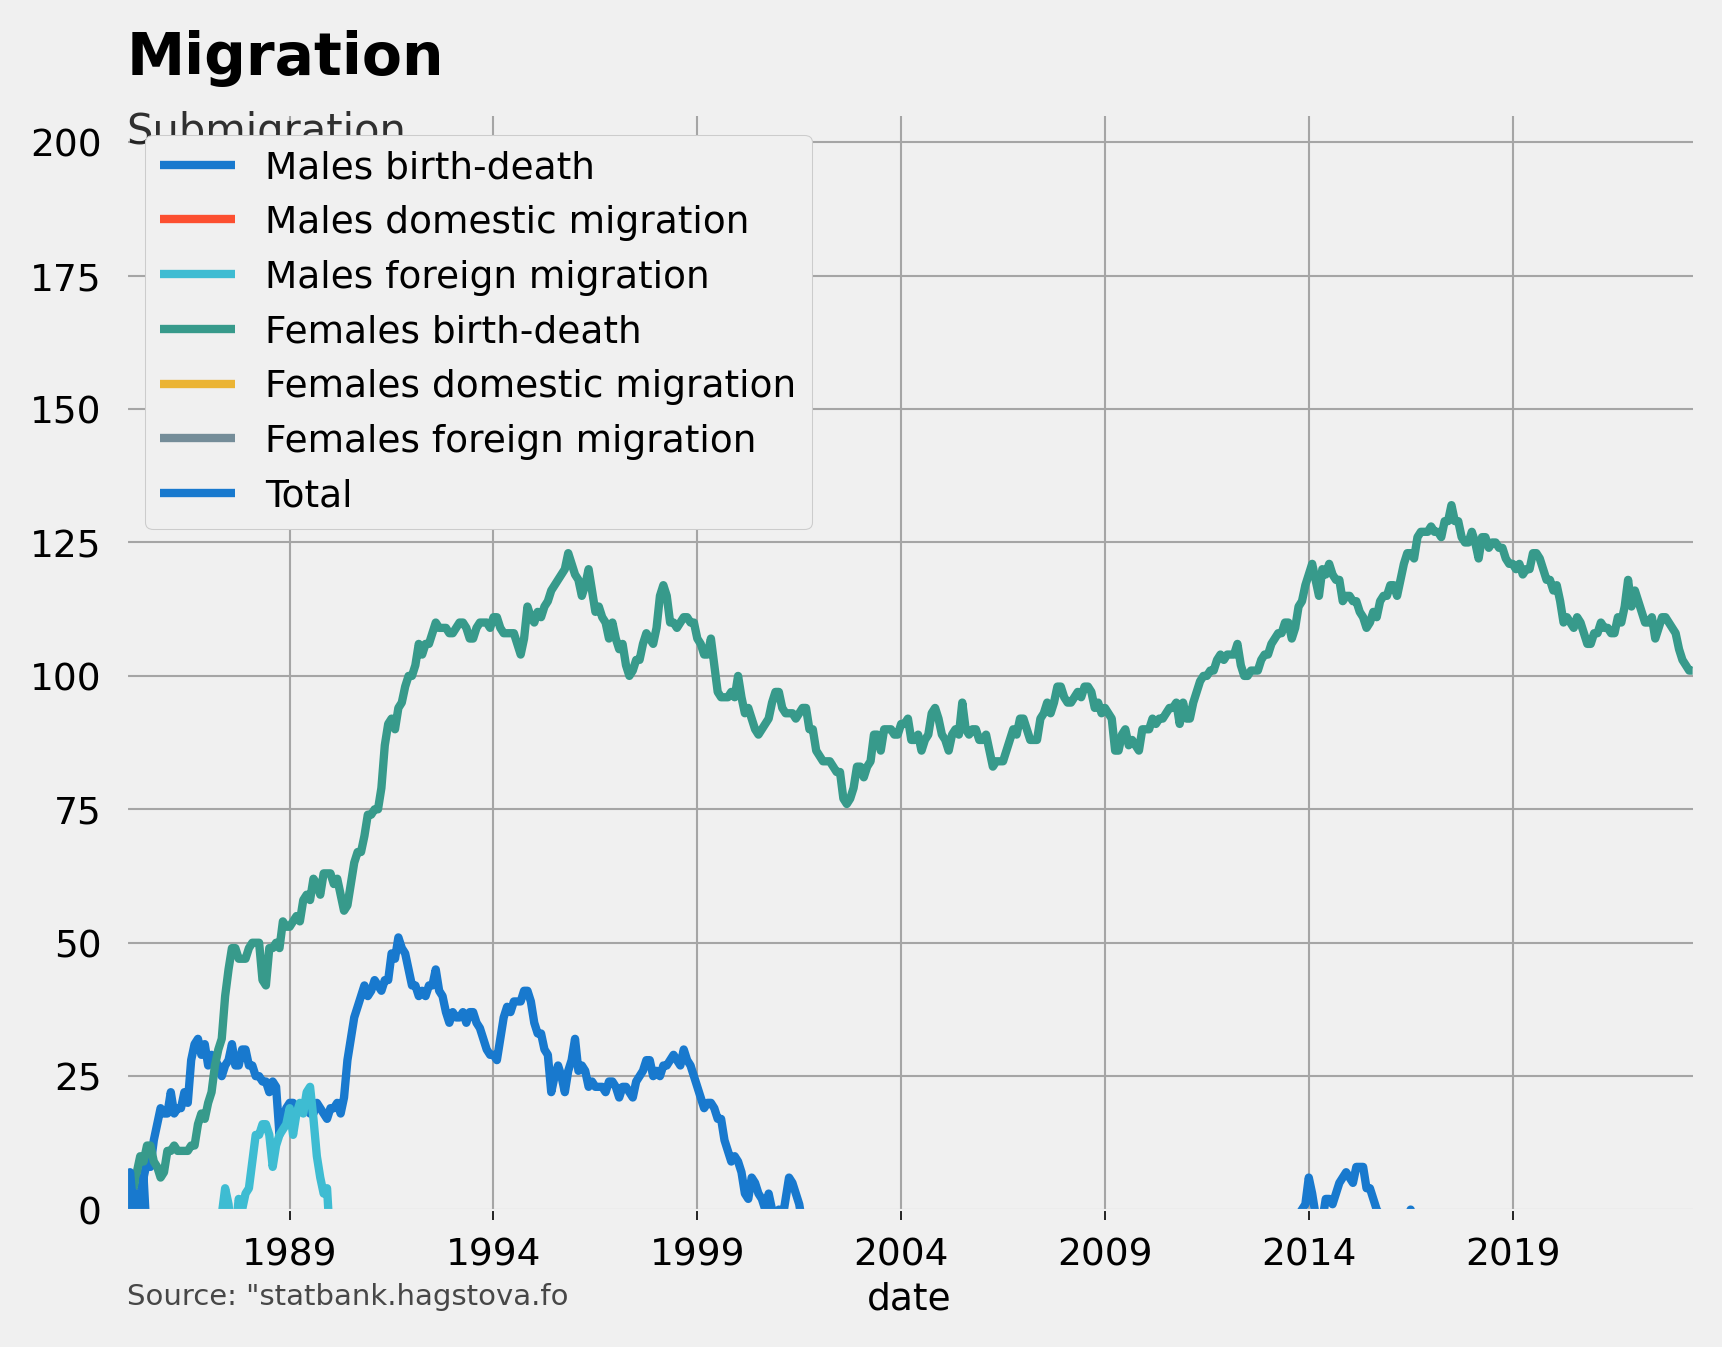

In [47]:
dp = rdf[plot_columns]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dp.drop(dp.tail(6).index,inplace=True)
ax = dp.plot( x='date', figsize=(12,9))
plt.legend(['Males birth-death', 'Males domestic migration', "Males foreign migration", "Females birth-death", "Females domestic migration", "Females foreign migration", "Total"])
ph.format_plot(ax, "Migration", "Submigration")
plt.show()

# Children

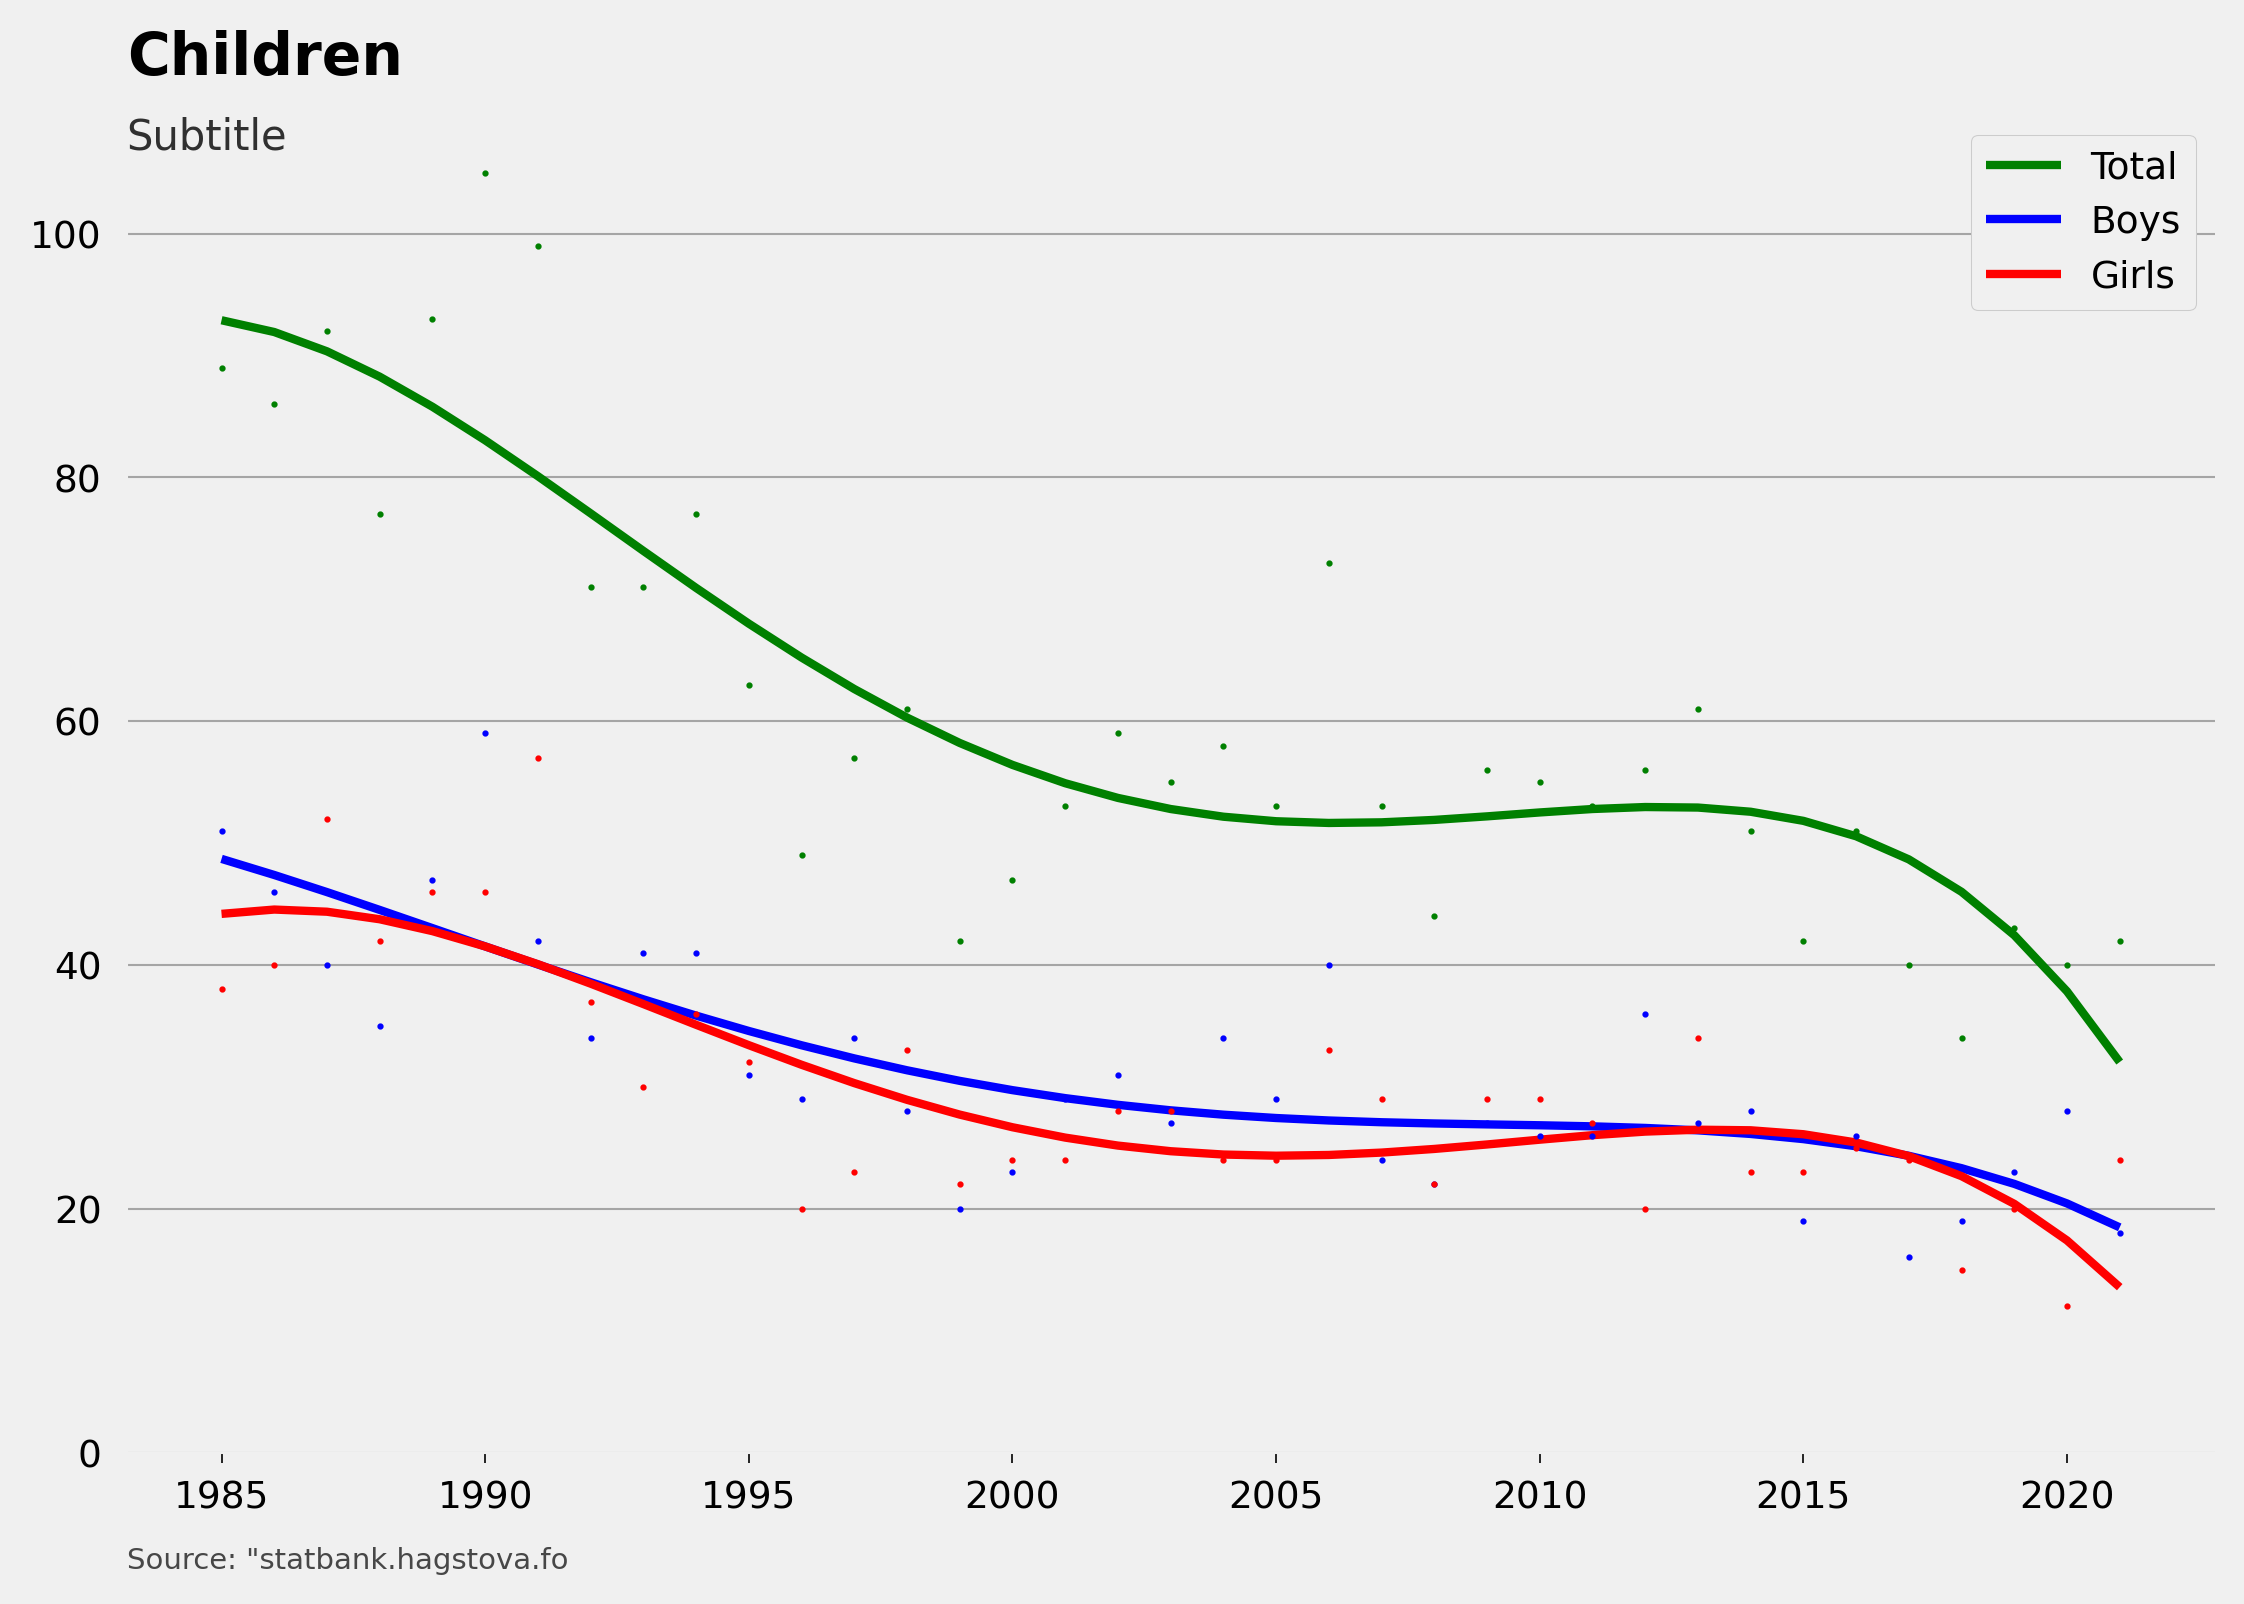

In [48]:
bdf = pd.DataFrame()
bdf["date"] =  rdf['date']
bdf["Males birth"] =  rdf['Males Live births']
bdf["Females birth"] =  rdf['Females Live births']
bdf["Births"] = rdf['Males Live births'] + rdf['Females Live births']
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bdf1 = bdf.groupby('date', as_index=False)['Births', "Males birth", "Females birth"].sum()
bdf1a = bdf1.set_index(bdf1['date'].rename('year').dt.year, append=True).swaplevel(0,1)

bdf2 = bdf1a.groupby(['year']).sum()

years = bdf2.index.values[:-2]
births = bdf2['Births'].values.flatten()[:-2]
births_males = bdf2['Males birth'].values.flatten()[:-2]
births_females = bdf2['Females birth'].values.flatten()[:-2]
#print(births)
deg = 4
coeff_birth = np.polyfit(years, births, deg) #deg of 1 for straight line
f1_birth = np.poly1d(coeff_birth)

coeff_male_birth = np.polyfit(years, births_males, deg) #deg of 1 for straight line
f1_male_birth = np.poly1d(coeff_male_birth)

coeff_female_birth = np.polyfit(years, births_females, deg) #deg of 1 for straight line
f1_female_birth = np.poly1d(coeff_female_birth)

plt.plot(years, f1_birth(years), 'g' )
plt.plot(years, f1_male_birth(years), 'b')
plt.plot(years, f1_female_birth(years), 'r')
plt.plot(years, births, 'go', ms=2)
plt.plot(years, births_males, 'bo', ms=2)
plt.plot(years, births_females, 'ro', ms=2)
plt.legend(['Total', 'Boys', "Girls"])
ax = plt.gca()
ph.format_plot(ax, "Children", "Subtitle")
plt.show()

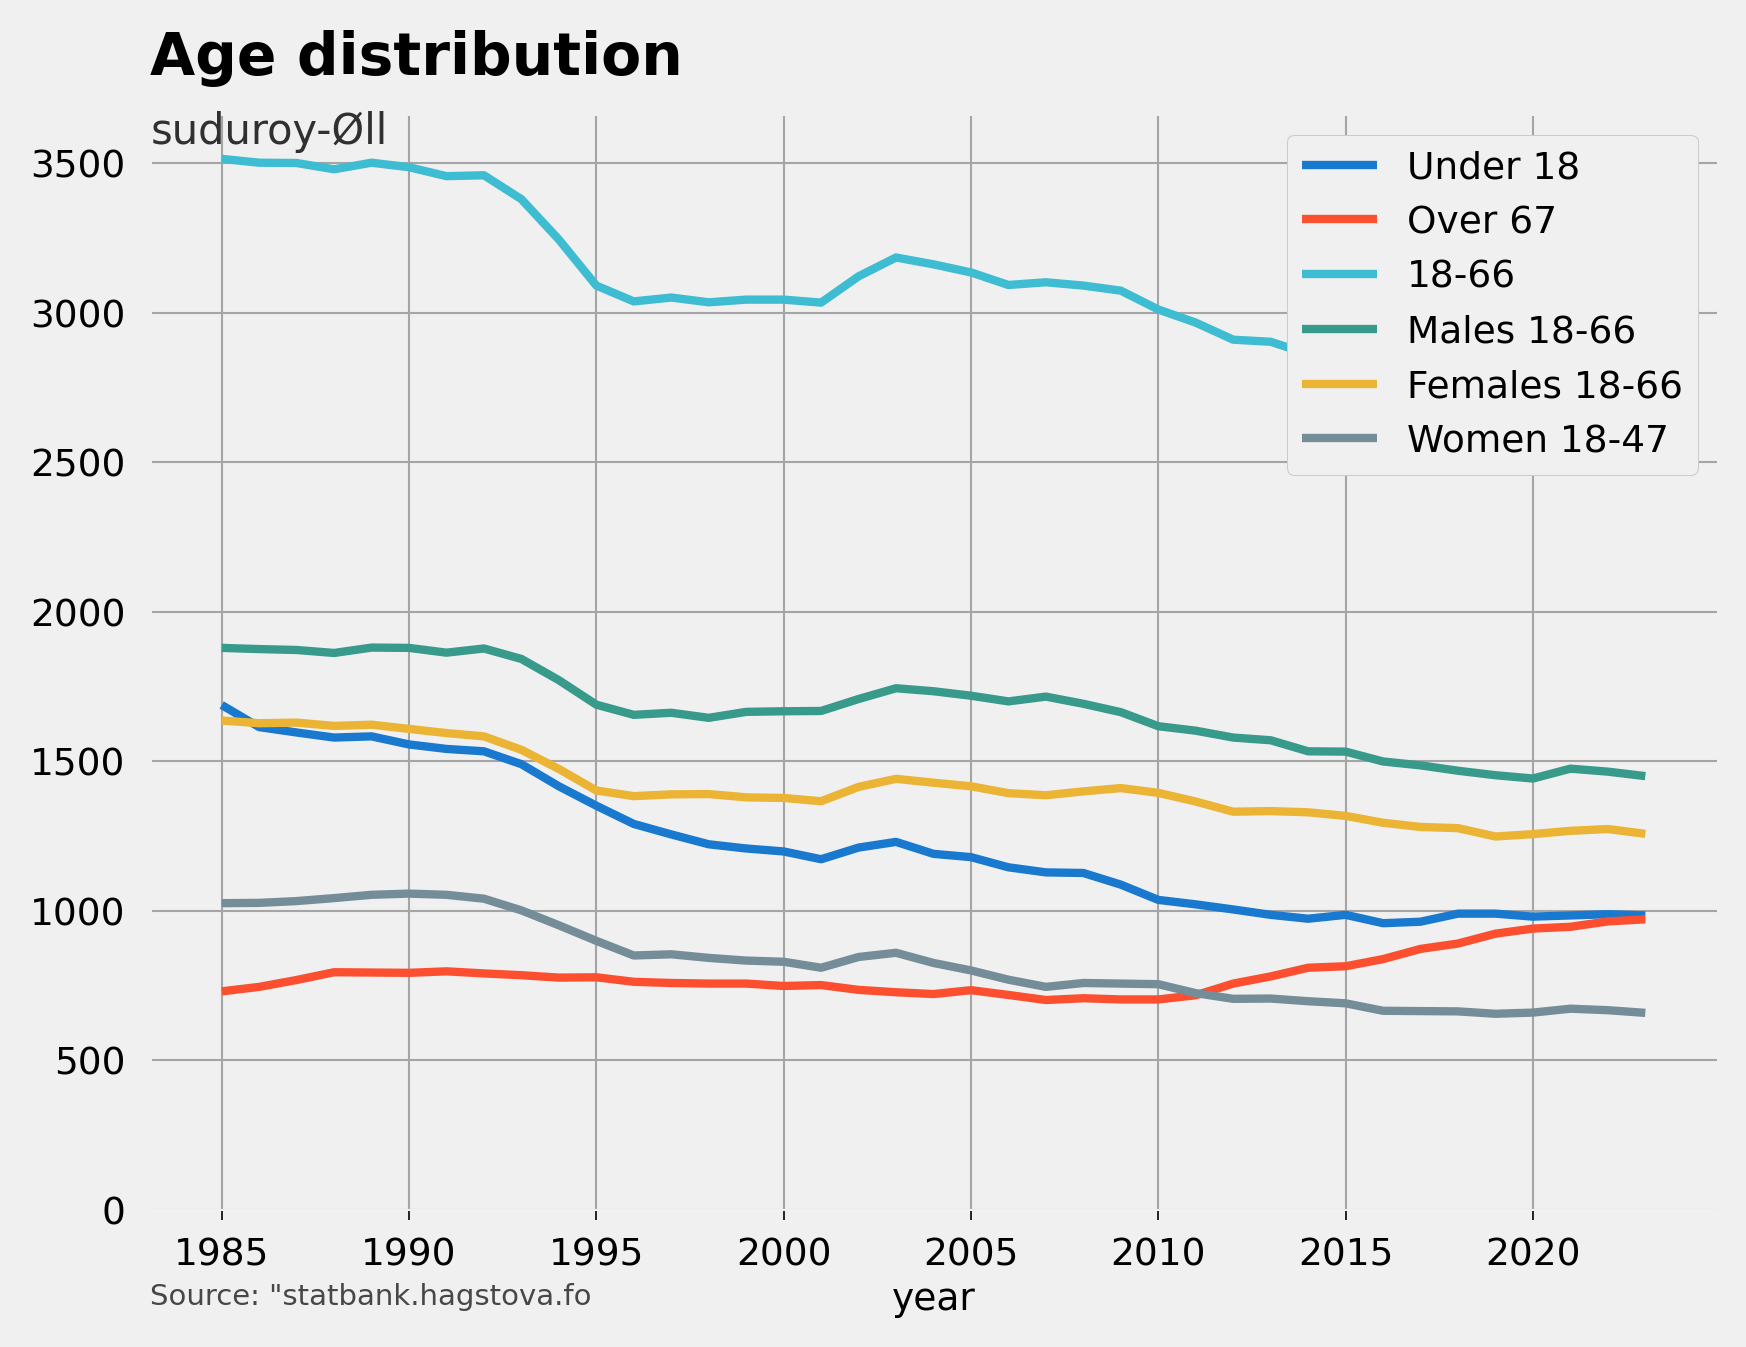

In [142]:
json_body = {
  "query": [
    {
      "code": "village/city",
      "selection": {
        "filter": "agg:municipality-en-2017.agg",
        "values": [
          "4602"
        ]
      }
    },
    {
      "code": "sex",
      "selection": {
        "filter": "item",
        "values": [
          "TOT",
          "M",
          "F"
        ]
      }
    },
    {
      "code": "month",
      "selection": {
        "filter": "item",
        "values": [
          "M01"
        ]
      }
    },
    {
      "code": "age",
      "selection": {
        "filter": "item",
        "values": [
          "TOTAL",
          "Y_LT1",
          "Y1",
          "Y2",
          "Y3",
          "Y4",
          "Y5",
          "Y6",
          "Y7",
          "Y8",
          "Y9",
          "Y10",
          "Y11",
          "Y12",
          "Y13",
          "Y14",
          "Y15",
          "Y16",
          "Y17",
          "Y18",
          "Y19",
          "Y20",
          "Y21",
          "Y22",
          "Y23",
          "Y24",
          "Y25",
          "Y26",
          "Y27",
          "Y28",
          "Y29",
          "Y30",
          "Y31",
          "Y32",
          "Y33",
          "Y34",
          "Y35",
          "Y36",
          "Y37",
          "Y38",
          "Y39",
          "Y40",
          "Y41",
          "Y42",
          "Y43",
          "Y44",
          "Y45",
          "Y46",
          "Y47",
          "Y48",
          "Y49",
          "Y50",
          "Y51",
          "Y52",
          "Y53",
          "Y54",
          "Y55",
          "Y56",
          "Y57",
          "Y58",
          "Y59",
          "Y60",
          "Y61",
          "Y62",
          "Y63",
          "Y64",
          "Y65",
          "Y66",
          "Y67",
          "Y68",
          "Y69",
          "Y70",
          "Y71",
          "Y72",
          "Y73",
          "Y74",
          "Y75",
          "Y76",
          "Y77",
          "Y78",
          "Y79",
          "Y80",
          "Y81",
          "Y82",
          "Y83",
          "Y84",
          "Y85",
          "Y86",
          "Y87",
          "Y88",
          "Y89",
          "Y90",
          "Y91",
          "Y92",
          "Y93",
          "Y94",
          "Y95",
          "Y96",
          "Y97",
          "Y98",
          "Y99",
          "Y100",
          "Y101",
          "Y102",
          "Y103",
          "Y104",
          "Y105",
          "Y106",
          "Y107",
          "Y108",
          "Y109",
          "Y110"
        ]
      }
    }
  ],
  "response": {
    "format": "px"
  }
}



sexes = ["Total (sex)","Males", "Females"]
#sexes = ["Total (sex)"]
changes = ["Jan"]
age_groups = {
    "children": range(1,18),
    "pre school":[1,2,3,4,5],
    "primary school":[6,7,8,9,10,11,12,13,14,15,16],
    "gym":[17,18,19],
    "birth age": range(17,46),
    "working age": range(17,67),
    "old age": range(67,110)
}


json_body["query"][0]["selection"]["filter"] = filter
json_body["query"][0]["selection"]["values"] = [value]

df = dh.fetch_data("v1/en/H2/IB/IB01/fo_abgd_md.px", json_body, f"people-age-data-{region.value}-{municipality.value}")
df['value']=pd.to_numeric(df['DATA'])
df = df.drop(columns=['village/city', 'DATA'])

#print(df)
dfr = pd.DataFrame()
#dfg['year'] = df['year'].loc[(df["sex"] == sex) & (df['month'] == 'Jan') & (df['age'] == "1 years" )].reset_index()['year']
        
for group in age_groups:
  filter_group = [str(x) + " years" for x in age_groups[group]]
  dfg =  df[df["age"].isin(filter_group)].groupby(by=['sex', 'year'], as_index=False).sum()
  dfg["sex"] = dfg["sex"].apply(lambda x: f"{x} {group}")
  dfr = pd.concat([dfr, dfg], ignore_index=True)
  #print(group)
  #display(dfg)
  #dfg =  df[df["age"].isin(filter_group)].groupby(by=['sex', 'year'], as_index=False)['value'].sum()
  #print(f"{group}", dfg)
  #dfg["sex"] = dfg["sex"].apply(lambda x: f"{x} {group}")

#print(dfr)
#display(dfr)
#dfg = dfg.reindex(columns=["sex", "year"])
dfp = pd.pivot_table(dfr, index='year', columns='sex', values = 'value')
#dfgx = dfgx.reindex()
dfp = dfp.reindex()
#display(dfp)



df_childhood_vs_old = dfp[["Total (sex) children", "Total (sex) old age", "Total (sex) working age", "Males working age", "Females working age", "Females birth age"]]
#display(df_childhood_vs_old)

ax = df_childhood_vs_old.plot(  figsize=(12,9), title="Tvøroyrar kommuna demographic development")
plt.legend(['Under 18', 'Over 67', "18-66", "Males 18-66", "Females 18-66", "Women 18-47"])
ph.format_plot(ax, "Age distribution", f"{region.value}-{municipality.value}")
plt.show()


#dfgx = dfg[dfg["month"].isin(["Jan"])]
#from IPython.display import display, HTML

#display(dfgx)

#dfg.head()
#rdf = pd.DataFrame()
#rdf['year'] = df['year'].loc[(df["sex"] == "Males") & (df['month'] == 'Jan') & (df['age'] == "1 years" )].reset_index()['year']

#xdf = df.groupby(['sex'])
#xdf.head()

